In [1]:
import hypothesis
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch.nn.utils import spectral_norm

In [2]:
mean_true = torch.tensor(1, dtype=torch.float)

normal = Normal(mean_true, 1.)
lower = torch.tensor(0, dtype=torch.float)
upper = torch.tensor(2, dtype=torch.float)
prior = Uniform(lower, upper)

In [3]:
def simulator(theta):
    normal = Normal(theta, 1)
    return normal.sample().view(-1)

In [4]:
from hypothesis.nn import ParameterizedClassifier
from hypothesis.nn import ParameterizedClassifierEnsemble

def allocate_classifier(hidden=128):
    classifier = torch.nn.Sequential(
        torch.nn.Linear(2, hidden),
        torch.nn.SELU(),
        spectral_norm(torch.nn.Linear(hidden, hidden)),
        torch.nn.SELU(),
        spectral_norm(torch.nn.Linear(hidden, hidden)),
        torch.nn.SELU(),
        spectral_norm(torch.nn.Linear(hidden, hidden)),
        torch.nn.SELU(),
        torch.nn.Linear(hidden, 1),
        torch.nn.Sigmoid())
    classifier = ParameterizedClassifier(classifier, lower=lower, upper=upper)
    classifier.train()
    
    return classifier

In [5]:
from hypothesis.io.dataset import GeneratorDataset as Dataset

dataset = Dataset(simulator, prior)

In [6]:
from hypothesis.train import ParameterizedClassifierTrainer as Trainer

def train():
    classifier = allocate_classifier()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.025)
    trainer = Trainer(classifier, dataset, optimizer, shuffle=True, epochs=25, batch_size=512)
    trainer.train()
    classifier.eval()
    
    return classifier

In [7]:
classifier = train()

In [25]:
num_classifiers = 5

#classifiers = []
for classifier_index in range(num_classifiers):
    print("Training classifier", classifier_index + 1)
    classifier = train()
    classifiers.append(classifier)

Training classifier 1
Training classifier 2
Training classifier 3
Training classifier 4
Training classifier 5


In [26]:
ensemble = ParameterizedClassifierEnsemble(classifiers)

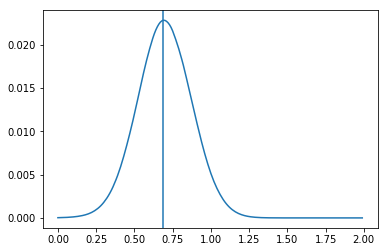

In [31]:
ensemble.eval()
thetas = torch.arange(lower, upper, 0.01)
observations = normal.sample(torch.Size([32]))

ratios = []
for theta in thetas:
    ratio = -ensemble.log_likelihood_to_evidence_ratio(observations, theta)
    ratios.append(ratio.exp())

total = sum(ratios)
for index in range(len(ratios)):
    ratios[index] /= total

plt.plot(thetas.detach().numpy(), ratios)
plt.axvline(observations.mean().numpy())
#plt.ylim([0, None])
plt.show()